1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)


-----

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

In [4]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

-----

In [5]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(
    df, df['Exited'], random_state=13)

In [7]:
# pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(
            X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
categorical_columns = ['Geography', 'Gender',
                       'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age',
                      'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('scaler', StandardScaler())
    ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
def metrics(y_true, y_pred):

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    plt.rc('font', **{'size': 15})
    cnf_matrix = confusion_matrix(y_test, y_pred > thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix_' + str(model.__class__.__name__))
    plt.savefig("conf_matrix.png")
    plt.show()
    fbeta_score_09 = fbeta_score(y_test, y_pred >= thresholds[ix], beta=0.9)
    return [thresholds[ix],  fscore[ix], fbeta_score_09, precision[ix], recall[ix]]

In [12]:
feature_processing = Pipeline([('feats', feats)])
X_train = feature_processing.fit_transform(X_train)
X_test = feature_processing.fit_transform(X_test)

In [13]:
model_xgb = XGBClassifier(random_state=13)
model_log_reg = LogisticRegression(random_state=13)

[18:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix, without normalization
[[1855  129]
 [ 231  285]]


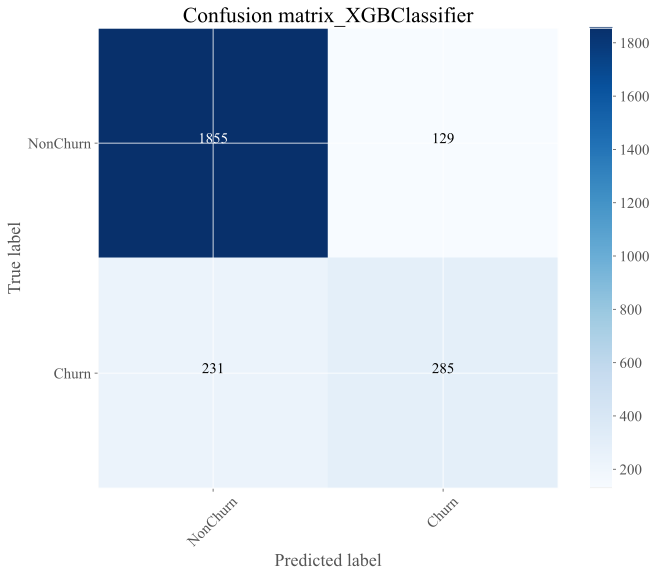

Confusion matrix, without normalization
[[1661  323]
 [ 236  280]]


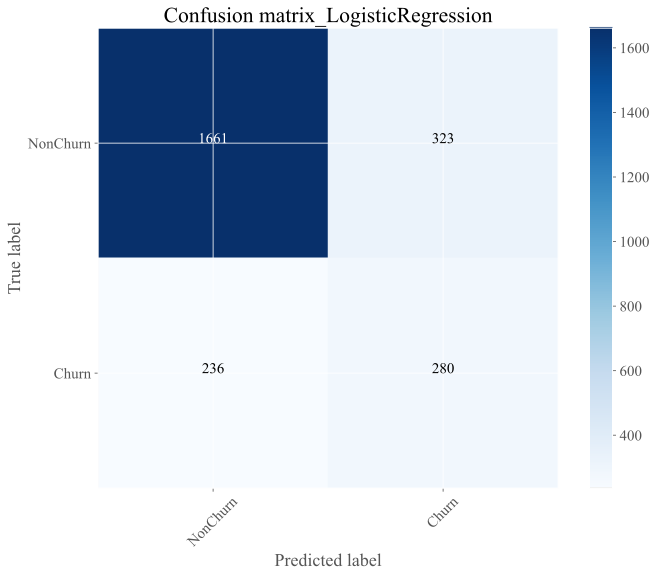

In [14]:
metrics_dict = {'metrics': [
    'best_threshold', 'best_fscore', 'fbeta_score_09', 'precision', 'recall']}
for model in [model_xgb, model_log_reg]:
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics_dict[model.__class__.__name__] = metrics(y_test, y_proba)

In [15]:
df_result = pd.DataFrame(metrics_dict)
df_result

,metrics,XGBClassifier,LogisticRegression
0,best_threshold,0.43,0.28
1,best_fscore,0.61,0.50
2,fbeta_score_09,0.62,0.50
3,precision,0.69,0.47
4,recall,0.55,0.54


С учетом того, что не стоит задача "удержать всех", и дальнейшая работа по удержанию ведется с лишь с частью клиентов (топ30/20 и т.д) наиболее подходящей метрикой будет fscore со сдвигом в сторону precision.

----

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [16]:
model_xgb = XGBClassifier(random_state=13)
model_xgb.fit(X_train, y_train)
y_proba = model_xgb.predict_proba(X_test)[:, 1]

[18:39:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:
TN, FP, FN, TP = confusion_matrix(
    y_test, y_proba > metrics_dict['XGBClassifier'][0]).ravel()

Т.К. очень кривое условие, считаем, что клиенты предсказанные как  FN уйдут в отток, и на привлечение такого же количество новых надо потратить 1 доллар.  2 доллара - с каждого правильно классифицированного (True Positive) удержанного 

In [18]:
e_effect = 2*TP - FN
e_effect

339

----

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [19]:
model_xgb = XGBClassifier(random_state=13)
parameters = {
    'max_depth': range(2, 7, 1),
    'n_estimators': range(100, 220, 40),
    'learning_rate': np.arange(0.01, 0.52, 0.05),
    'reg_lambda': np.arange(0.7, 2.01, 0.1)
}

In [20]:
# clf = GridSearchCV(model_xgb, parameters, n_jobs=-1,
#                    cv=StratifiedKFold(shuffle=True),
#                    scoring='f1',
#                    verbose=1, refit=True)

# clf.fit(X_train, y_train)
# clf.best_params_
# {'learning_rate': 0.11, 'max_depth': 5, 'n_estimators': 180, 'reg_lambda': 1.9}

In [21]:
disbalance = df['Exited'].value_counts()[0] / df['Exited'].value_counts()[1]

model = XGBClassifier(
    random_state=13,
    learning_rate=0.11,
    max_depth=5,
    n_estimators=180,
    reg_lambda=1.9,
    scale_pos_weight=disbalance
)
model.fit(X_train, y_train)

[18:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.11, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=16, num_parallel_tree=1, random_state=13,
              reg_alpha=0, reg_lambda=1.9, scale_pos_weight=3.9091801669121256,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Confusion matrix, without normalization
[[1757  227]
 [ 166  350]]


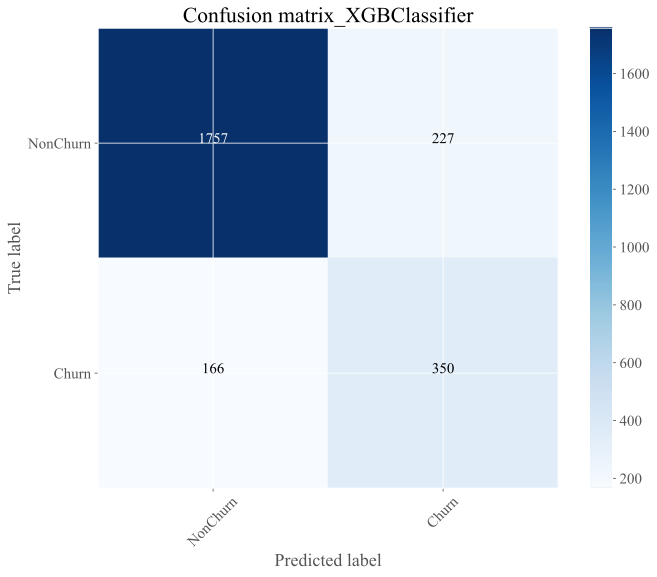

best_threshold :  0.55570704
best_fscore :  0.6416819012797075
fbeta_score_09 :  0.6378870637374995
precision :  0.6072664359861591
recall :  0.6802325581395349


In [22]:
y_proba = model.predict_proba(X_test)[:, 1]
metrics = metrics(y_test, y_proba)
for num, metric in enumerate(['best_threshold', 'best_fscore', 'fbeta_score_09', 'precision', 'recall']):
    print(metric, ": ", metrics[num])

5. (опционально) Еще раз провести оценку экономической эффективности

In [23]:
TN, FP, FN, TP = confusion_matrix(
    y_test, y_proba > metrics[0]).ravel()

In [24]:
e_effect_2 = 2*TP - FN
e_effect_2

534